### Step 1: CNN Classification with K-Fold and SMOTE Balancing

This notebook implements a CNN architecture for text classification and compares three experimental setups:
1. **Baseline CNN**: Standard train-test split (Without K-Fold).
2. **K-Fold CNN**: 5-Fold Cross-Validation for a more robust evaluation.
3. **SMOTE + K-Fold CNN**: Balancing the dataset using SMOTE to handle class imbalance before performing 5-Fold Cross-Validation.

Architecture:
* **Tokenizer**: Converts text into sequences.
* **Embedding Layer**: Dense vector representations.
* **Conv1D**: Local pattern detection.
* **GlobalMaxPooling1D**: Feature extraction.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from IPython.display import display

# Load Data
df = pd.read_csv('(A) Data/(A) PreProcessed_News Content Title_3000 Data.csv', usecols=['Detokenized', 'Labelling'], engine='python')
df = df.dropna()

# Map labels to 0, 1, 2
label_mapping = {-1: 0, 0: 1, 1: 2}
df['label_encoded'] = df['Labelling'].map(label_mapping)

X = df['Detokenized'].values
y = df['label_encoded'].values

print(f"Data Shape: {df.shape}")
print("Class Distribution:\n", df['label_encoded'].value_counts())

Data Shape: (2791, 3)
Class Distribution:
 label_encoded
1    1331
0    1026
2     434
Name: count, dtype: int64


### 1. Sequence Preprocessing

In [ ]:
# Hyperparameters
vocab_size = 5000   # Keep the Top 5,000 Most Frequent Words
embedding_dim = 100
max_length = 100
oov_tok = "<OOV>"   # For Handling Words not in the vocabulary

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

# Convert to Sequences and Pad
sequences = tokenizer.texts_to_sequences(X)
padded_X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Found {len(tokenizer.word_index)} unique tokens.")
# "Found 6142 unique tokens, Words ranked 5001 to 6142 are treated as Out of Vocabulary (OOV)"

Found 6142 unique tokens.


### 2. Model Definition
We define a function so we can re-initialize the model for each trial.

In [5]:
def create_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(24, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### 3. Experiment 1: CNN Without K-Fold Validation
Using a standard 80/20 train-test split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, random_state=42)

print("Training Baseline Model...")
baseline_model = create_model()
baseline_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred = np.argmax(baseline_model.predict(X_test), axis=1)
baseline_report = classification_report(y_test, y_pred)
print("\nBaseline Classification Report (Without K-Fold):")
print(baseline_report)
baseline_acc = accuracy_score(y_test, y_pred)

Training Baseline Model...
Epoch 1/15
70/70 [==============================] - 2s 19ms/step - loss: 1.0295 - accuracy: 0.4754 - val_loss: 0.9728 - val_accuracy: 0.5045
Epoch 2/15
70/70 [==============================] - 1s 14ms/step - loss: 0.8816 - accuracy: 0.6210 - val_loss: 0.7854 - val_accuracy: 0.6780
Epoch 3/15
70/70 [==============================] - 1s 14ms/step - loss: 0.5846 - accuracy: 0.7746 - val_loss: 0.7171 - val_accuracy: 0.6923
Epoch 4/15
70/70 [==============================] - 1s 14ms/step - loss: 0.3522 - accuracy: 0.8786 - val_loss: 0.7814 - val_accuracy: 0.7013
Epoch 5/15
70/70 [==============================] - 1s 14ms/step - loss: 0.2243 - accuracy: 0.9297 - val_loss: 0.9104 - val_accuracy: 0.6941
Epoch 6/15
70/70 [==============================] - 1s 15ms/step - loss: 0.1715 - accuracy: 0.9507 - val_loss: 1.0128 - val_accuracy: 0.6905
Epoch 7/15
70/70 [==============================] - 1s 15ms/step - loss: 0.1401 - accuracy: 0.9588 - val_loss: 1.1257 - val_acc

### 4. Experiment 2: CNN With K-Fold Validation
Using 5-Fold Cross-Validation on the original imbalanced dataset.

In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results_list = []
fold_no = 1

for train, test in kfold.split(padded_X, y):
    print(f'Training fold {fold_no}...')
    model = create_model()
    model.fit(padded_X[train], y[train], epochs=15, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(padded_X[test]), axis=1)
    report = classification_report(y[test], y_pred, output_dict=True, labels=[0, 1, 2])
    
    results_list.append({
        'Fold': f'Group {fold_no}',
        'Accuracy': accuracy_score(y[test], y_pred),
        'Prec Class 0': report['0']['precision'],
        'Prec Class 1': report['1']['precision'],
        'Prec Class 2': report['2']['precision'],
        'Recall Class 0': report['0']['recall'],
        'Recall Class 1': report['1']['recall'],
        'Recall Class 2': report['2']['recall'],
        'F1 Class 0': report['0']['f1-score'],
        'F1 Class 1': report['1']['f1-score'],
        'F1 Class 2': report['2']['f1-score']
    })
    fold_no += 1

results_df = pd.DataFrame(results_list).set_index('Fold')
summary_stats = pd.DataFrame({'Max value': results_df.max(), 'min': results_df.min(), 'Average': results_df.mean(), 'stdev': results_df.std()}).T
final_kfold_table = pd.concat([results_df, summary_stats])

print("\nExperiment 2: K-Fold Results (Imbalanced Data):")
display(final_kfold_table.style.format("{:.4f}"))
exp2_avg_acc = results_df['Accuracy'].mean()

Training fold 1...
18/18 [==============================] - 0s 4ms/step
Training fold 2...
18/18 [==============================] - 0s 4ms/step
Training fold 3...
18/18 [==============================] - 0s 4ms/step
Training fold 4...
18/18 [==============================] - 0s 4ms/step
Training fold 5...
18/18 [==============================] - 0s 4ms/step

Experiment 2: K-Fold Results (Imbalanced Data):


,Accuracy,Prec Class 0,Prec Class 1,Prec Class 2,Recall Class 0,Recall Class 1,Recall Class 2,F1 Class 0,F1 Class 1,F1 Class 2
Group 1,0.6852,0.7236,0.7070,0.5287,0.7059,0.7070,0.5610,0.7146,0.7070,0.5444
Group 2,0.6703,0.6380,0.7091,0.6129,0.7382,0.7169,0.4000,0.6845,0.7130,0.4841
Group 3,0.6667,0.6814,0.7000,0.5244,0.7299,0.6506,0.5513,0.7048,0.6744,0.5375
Group 4,0.6470,0.6847,0.6391,0.5472,0.6588,0.7228,0.3625,0.6715,0.6784,0.4361
Group 5,0.6685,0.7019,0.6744,0.5761,0.6986,0.6960,0.5354,0.7002,0.6850,0.5550
Max value,0.6852,0.7236,0.7091,0.6129,0.7382,0.7228,0.5610,0.7146,0.7130,0.5550
min,0.6470,0.6380,0.6391,0.5244,0.6588,0.6506,0.3625,0.6715,0.6744,0.4361
Average,0.6675,0.6859,0.6859,0.5579,0.7063,0.6987,0.4820,0.6951,0.6915,0.5114
stdev,0.0136,0.0316,0.0296,0.0369,0.0312,0.0288,0.0934,0.0171,0.0174,0.0502


### 5. Experiment 3: SMOTE Dataset + CNN + K-Fold Validation
In this experiment, we apply SMOTE to balance the training data *within each fold* to prevent data leakage.

In [8]:
smote = SMOTE(random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
smote_results_list = []
fold_no = 1

for train, test in kfold.split(padded_X, y):
    print(f'Training fold {fold_no} (with SMOTE)...')
    
    # Apply SMOTE to the TRAINING set of the fold only
    X_train_fold, y_train_fold = padded_X[train], y[train]
    X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)
    
    if fold_no == 1:
        print(f"Original training shape: {X_train_fold.shape}")
        print(f"Resampled training shape: {X_train_res.shape}")
        print("New Class Distribution:", pd.Series(y_train_res).value_counts())

    model = create_model()
    model.fit(X_train_res, y_train_res, epochs=15, batch_size=32, verbose=0)
    
    y_pred = np.argmax(model.predict(padded_X[test]), axis=1)
    report = classification_report(y[test], y_pred, output_dict=True, labels=[0, 1, 2])
    
    smote_results_list.append({
        'Fold': f'Group {fold_no}',
        'Accuracy': accuracy_score(y[test], y_pred),
        'Prec Class 0': report['0']['precision'],
        'Prec Class 1': report['1']['precision'],
        'Prec Class 2': report['2']['precision'],
        'Recall Class 0': report['0']['recall'],
        'Recall Class 1': report['1']['recall'],
        'Recall Class 2': report['2']['recall'],
        'F1 Class 0': report['0']['f1-score'],
        'F1 Class 1': report['1']['f1-score'],
        'F1 Class 2': report['2']['f1-score']
    })
    fold_no += 1

smote_results_df = pd.DataFrame(smote_results_list).set_index('Fold')
smote_summary_stats = pd.DataFrame({'Max value': smote_results_df.max(), 'min': smote_results_df.min(), 'Average': smote_results_df.mean(), 'stdev': smote_results_df.std()}).T
final_smote_table = pd.concat([smote_results_df, smote_summary_stats])

print("\nExperiment 3: SMOTE + K-Fold Results:")
display(final_smote_table.style.format("{:.4f}"))

Training fold 1 (with SMOTE)...
Original training shape: (2232, 100)
Resampled training shape: (3174, 100)
New Class Distribution: 2    1058
0    1058
1    1058
Name: count, dtype: int64
18/18 [==============================] - 0s 4ms/step
Training fold 2 (with SMOTE)...
18/18 [==============================] - 0s 4ms/step
Training fold 3 (with SMOTE)...
18/18 [==============================] - 0s 4ms/step
Training fold 4 (with SMOTE)...
18/18 [==============================] - 0s 4ms/step
Training fold 5 (with SMOTE)...
18/18 [==============================] - 0s 4ms/step

Experiment 3: SMOTE + K-Fold Results:


,Accuracy,Prec Class 0,Prec Class 1,Prec Class 2,Recall Class 0,Recall Class 1,Recall Class 2,F1 Class 0,F1 Class 1,F1 Class 2
Group 1,0.6565,0.7059,0.7671,0.4044,0.7059,0.6154,0.6707,0.7059,0.6829,0.5046
Group 2,0.6254,0.6587,0.7465,0.3759,0.7173,0.5956,0.5263,0.6867,0.6626,0.4386
Group 3,0.6075,0.6481,0.7051,0.3680,0.6635,0.5688,0.5897,0.6557,0.6296,0.4532
Group 4,0.5771,0.6634,0.7047,0.3190,0.6351,0.5094,0.6500,0.6489,0.5913,0.4280
Group 5,0.5824,0.6667,0.6744,0.3444,0.6124,0.5800,0.5253,0.6384,0.6237,0.4160
Max value,0.6565,0.7059,0.7671,0.4044,0.7173,0.6154,0.6707,0.7059,0.6829,0.5046
min,0.5771,0.6481,0.6744,0.3190,0.6124,0.5094,0.5253,0.6384,0.5913,0.4160
Average,0.6098,0.6685,0.7196,0.3623,0.6668,0.5738,0.5924,0.6671,0.6380,0.4481
stdev,0.0326,0.0220,0.0369,0.0324,0.0449,0.0401,0.0677,0.0282,0.0356,0.0344


### 6. Final Comparison Summary

In [11]:
print("--- Overall Accuracy Comparison ---")
print(f"Experiment 1 (No K-Fold):          {baseline_acc:.4f}")
print(f"Experiment 2 (K-Fold, Imbalanced): {exp2_avg_acc:.4f}")
print(f"Experiment 3 (K-Fold + SMOTE):     {smote_results_df['Accuracy'].mean():.4f}")

print("\nCheck the recall and F1-score for Class 2 (Positive) in Experiment 3 to see if SMOTE improved detection of the minority class.")

--- Overall Accuracy Comparison ---
Experiment 1 (No K-Fold):          0.6923
Experiment 2 (K-Fold, Imbalanced): 0.6675
Experiment 3 (K-Fold + SMOTE):     0.6098

Check the recall and F1-score for Class 2 (Positive) in Experiment 3 to see if SMOTE improved detection of the minority class.


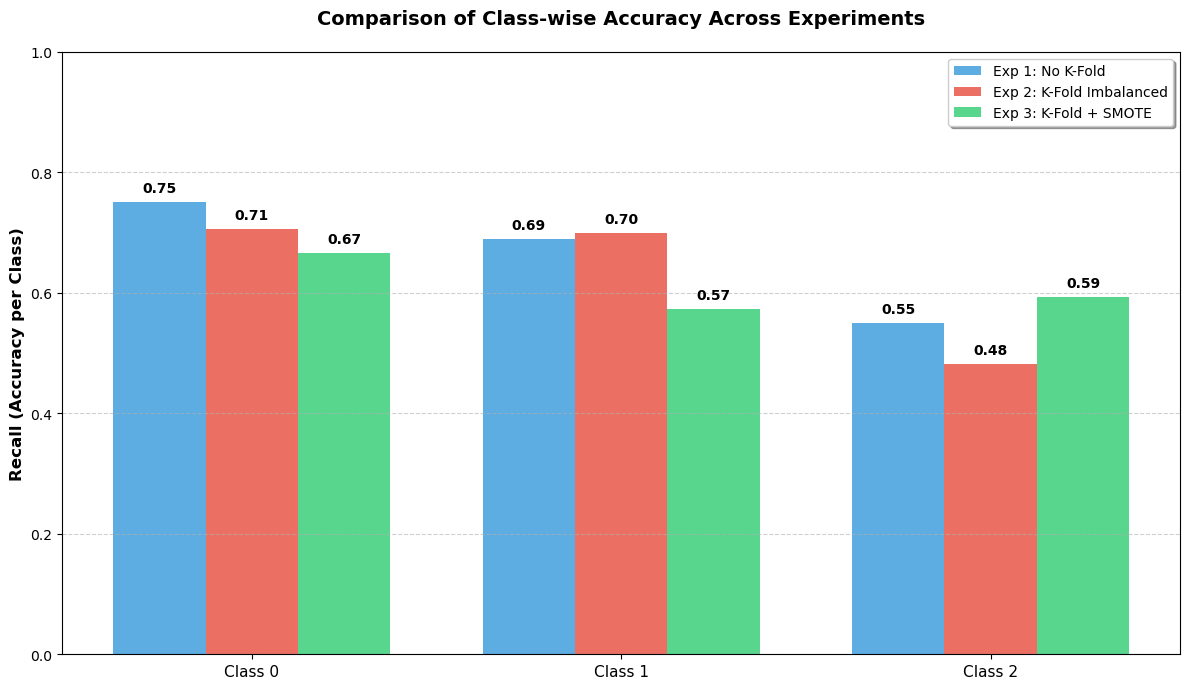

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the experiments
classes = ['Class 0', 'Class 1', 'Class 2']

# Experiment 1 (No K-Fold) - Recall values (Accuracy per class)
exp1_recall = [0.75, 0.69, 0.55]

# Experiment 2 (K-Fold, Imbalanced) - Average Recall values
exp2_recall = [0.7063, 0.6987, 0.4820]

# Experiment 3 (K-Fold & SMOTE) - Average Recall values
exp3_recall = [0.6668, 0.5738, 0.5924]

x = np.arange(len(classes))  # Label locations
width = 0.25  # Width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot bars with professional colors
rects1 = ax.bar(x - width, exp1_recall, width, label='Exp 1: No K-Fold', color='#3498db', alpha=0.8)
rects2 = ax.bar(x, exp2_recall, width, label='Exp 2: K-Fold Imbalanced', color='#e74c3c', alpha=0.8)
rects3 = ax.bar(x + width, exp3_recall, width, label='Exp 3: K-Fold + SMOTE', color='#2ecc71', alpha=0.8)

# Add chart text and labels
ax.set_ylabel('Recall (Accuracy per Class)', fontsize=12, fontweight='bold')
ax.set_title('Comparison of Class-wise Accuracy Across Experiments', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=11)
ax.legend(fontsize=10, loc='upper right', frameon=True, shadow=True)
ax.set_ylim(0, 1.0)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Function to add values on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()